In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/My Drive/DS_Work/OCR Kernel
!drive
!ls

/content/drive/My Drive/DS_Work/OCR Kernel
 Dataset  'OCR Kernel with Tesseract OCR.ipynb'


In [ ]:
PATH_DATA_CSV = "Dataset/Train.csv"

## Reading PDFs

In [ ]:
import pandas as pd

data_csv = pd.read_csv(PATH_DATA_CSV)
data_csv.head()

,FileName,Total Amount
0,TR_1,56.58
1,TR_2,69.25
2,TR_3,7.61
3,TR_4,5.35
4,TR_5,15.03


## Extracting images from the PDFs

In [ ]:
!pip install PyMuPDF

In [ ]:
import os
import fitz as mupdf
from tqdm import tqdm

for filename in tqdm(data_csv['FileName']):

    PATH_PDF = "Dataset/Train/" + filename + ".pdf"
    PATH_IMG_DIR = "Dataset/Train/Images/"
    if 'Images' not in os.listdir(PATH_IMG_DIR[:-8]):
        os.makedirs(PATH_IMG_DIR)

    pdf_obj = mupdf.open(PATH_PDF)

    for page in range(len(pdf_obj)):

        for index, img in enumerate(pdf_obj.getPageImageList(page)):

            img_obj_no = img[0]
            pix = mupdf.Pixmap(pdf_obj, img_obj_no)
            
            # .n gives number of components per pixel
            # Always contains alpha channel
            if pix.n < 5:
                # is GRAY or RGB
                pix.writePNG(PATH_IMG_DIR + filename + "-p" + str(page) + "-n" + str(img_obj_no) + ".png")
            else:
                # is CMYK, convert to RGB
                pix_converted = mupdf.Pixmap(mupdf.csRGB, pix)
                pix_converted.writePNG(PATH_IMG_DIR + filename + "-p" + str(page) + "-n" + str(img_obj_no) + ".png")
            
            img_obj_no = None

100%|██████████| 190/190 [00:35<00:00,  5.42it/s]


## Testing OCR Quality

In [ ]:
import cv2
import matplotlib.pyplot as plt

def image_preprocessing(path):
    img = cv2.imread(path,0)
    img = cv2.medianBlur(img,5)

    ret, th1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
    
    th2 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                cv2.THRESH_BINARY, 11, 2)
    
    th3 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                cv2.THRESH_BINARY, 11, 2)
    
    titles = ['Original Image', 'Global Thresholding (v = 127)',
            'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
    
    return {i:j for i, j in zip(titles, [img, th1, th2, th3])}

In [ ]:
import pytesseract

preprocessed_imgs = image_preprocessing('Dataset/Train/Images/TR_104-p0-n640.png')

for key in preprocessed_imgs:
    print(key)
    pytesseract.image_to_string(preprocessed_imgs[key])
    print('\n')

Original Image


Global Thresholding (v = 127)


Adaptive Mean Thresholding


Adaptive Gaussian Thresholding




In [ ]:
tesseract_config = r'-c tessedit_char_whitelist=$0123456789.: --psm 6'

In [ ]:
a = 'cashtotaldueamountbalancedrivethru-:grand$.,'
print(''.join(sorted(list(set(a)))).upper())

$,-.:ABCDEGHILMNORSTUV


In [ ]:
base = r'-c tessedit_char_whitelist=subtotalSUBTOTAL$0123456789.: --psm 6'

# custom_config = r'--psm 0 --oem 1 --tessdata-dir'
custom_config = r'-c tessedit_char_whitelist=abcdeghilmnorstuvABCDEGHILMNORSTUV1234567890$,-.: --psm 0 --oem 2 --tessdata-dir'

In [ ]:
from keras.preprocessing.image import load_img

ocr_text = {}

for filename in tqdm(os.listdir(PATH_IMG_DIR)):
    img = load_img(PATH_IMG_DIR + filename)
    
    text = pytesseract.image_to_string(img, config=custom_config)
    ocr_text[filename] = text

100%|██████████| 190/190 [04:29<00:00,  1.42s/it]


## Creating and using a preprocessing filter to improve performance

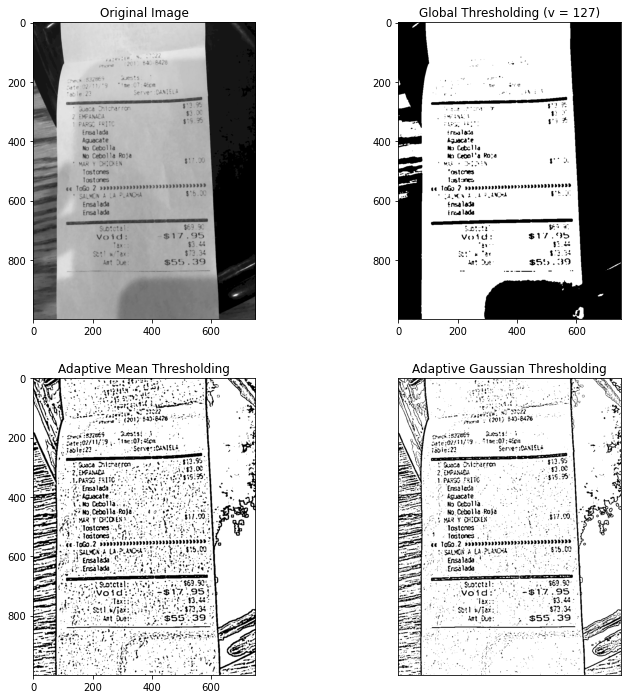

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12));

img_dict = image_preprocessing(PATH_IMG_DIR + os.listdir(PATH_IMG_DIR)[42])

for i, key in enumerate(img_dict.keys()):
    x = i%2
    y = round(i/2 - 0.25)
    ax[y][x].imshow(img_dict[key], 'gray')
    ax[y][x].title.set_text(key)
    plt.xticks([])
    plt.yticks([])
plt.show();

In [ ]:
ocr_text_rectified = {}

for filename in ocr_text.keys():
    if ocr_text[filename] == '':
        img = image_preprocessing(PATH_IMG_DIR + filename)

        ocr_text[filename] = pytesseract.image_to_string(img)
        ocr_text_rectified[filename] = ocr_text[filename]

## Finding Cumulative Amount using RegEx

In [ ]:
def decimal_formatting(string):
    req = string
    req = req.replace(' ', '.')
    req = req.replace(',', '.')
    req = '.'.join([chunk for chunk in req.split('.') if len(chunk) > 0])
    if len(req.split('.')[-1]) > 2:
        req = '0.0'
    try:
        req = float(req)
    except:
        req = 0.0
    return req

In [ ]:
import re

ocr_predicted = {}

for filename in ocr_text.keys():
    try:
        for line in ocr_text[filename].split('\n')[::-1]:
            # checking for regex matches in bottom-up fashion

            re_result = {}
            re_result['amount'] = re.search(r'\b(\w*amount\w*)\b', line.lower())
            re_result['cash'] = re.search(r'\b(\w*cash\w*)\b', line.lower())
            re_result['total'] = re.search(r'\b(\w*total\w*)\b', line.lower())

            if (re_result['amount'] != None) | (re_result['cash'] != None) | (re_result['total'] != None):
                # Found a keyword in a line
                # Now look for decimal number matches
                
                matching_numbers = re.findall(r'\d+\.\d+', line.lower())
                matching_numbers += re.findall(r'\d+\ \.\d+', line.lower())
                matching_numbers += re.findall(r'\d+\.\ \d+', line.lower())
                matching_numbers += re.findall(r'\d+\,\d+', line.lower())
                matching_numbers += re.findall(r'\d+\ \,\d+', line.lower())
                matching_numbers += re.findall(r'\d+\,\ \d+', line.lower())

                matching_numbers = list(map(decimal_formatting, matching_numbers))

                if len(matching_numbers) >= 1:
                    ocr_predicted[filename] = max(matching_numbers)
                    # found a matching number in a line with 
                    # descriptive keyword. ending search now.
                    # raising an exception to exit the block for this image
                    assert False

                if len(matching_numbers) == 0:
                    # No matching numbers found in this line
                    # Continue looking in the lines above
                    continue
                    
        # once traversed through all lines with 
        # descriptive keyword, if matching numbers
        # is still 0, ie, no matches found, start
        # looking for all numbers in the image.
        # assign the greatest number found under
        # 100,000.00 as the total. if this fails,
        # assign 0.00 as total.

        full_text_lower = ocr_text[filename].lower()

        matching_numbers = re.findall(r'\d+\.\d+', full_text_lower)
        matching_numbers += re.findall(r'\d+\ .\d+', full_text_lower)
        matching_numbers += re.findall(r'\d+\. \d+', full_text_lower)
        matching_numbers += re.findall(r'\d+\,\d+', full_text_lower)
        matching_numbers += re.findall(r'\d+\ ,\d+', full_text_lower)
        matching_numbers += re.findall(r'\d+\, \d+', full_text_lower)

        matching_numbers = list(map(decimal_formatting, matching_numbers))
        matching_numbers = list(filter(lambda x: x < 100000.00, matching_numbers))

        if len(matching_numbers) >= 1:
            ocr_predicted[filename] = max(matching_numbers)
            
            # raising exception to get out of block
            # and go to the next image
            assert False

        if len(matching_numbers) == 0:
            # No numbers found in the entirety of image.
            # Assign 0 as total.
            
            ocr_predicted[filename] = 0.00
            continue
    except:
        # Found a successful decimal number match
        # Going the the next image now
        continue   

## Setting failed predictions to average of predicted

In [ ]:
failed_predictions = [key for key in ocr_predicted.keys() if ocr_predicted[key] == 0.0]
predictions_total = sum([ocr_predicted[key] for key in ocr_predicted.keys()])

average_prediction = predictions_total / (len(ocr_predicted.keys()) - len(failed_predictions))

for key in failed_predictions:
    ocr_predicted[key] = round(average_prediction, ndigits=2)

In [ ]:
keys = []
values = []

for key in ocr_predicted.keys():
    keys.append(key.split('-')[0])
    values.append(round(ocr_predicted[key], ndigits=2))

In [ ]:
train_pred = pd.DataFrame({'FileName': keys, 'Total Amount': values})

In [ ]:
data_csv

,FileName,Total Amount
0,TR_1,56.58
1,TR_2,69.25
2,TR_3,7.61
3,TR_4,5.35
4,TR_5,15.03
...,...,...
185,TR_186,15593.00
186,TR_187,64.29
187,TR_188,70.68
188,TR_189,30.81


In [ ]:
data_csv.to_csv('submission.csv', index=False)

In [ ]:
from sklearn.metrics import r2_score

scoring_metric = 100 * r2_score(data_csv['Total Amount'], train_pred['Total Amount'])
print(f'R2 Score: {scoring_metric}')

R2 Score: 99.1706930340248


In [ ]:
PATH_DATA_TEST_CSV = "Dataset/Test.csv"

In [ ]:
data_test = pd.read_csv(PATH_DATA_TEST_CSV)

In [ ]:
for filename in tqdm(data_test['FileName']):

    PATH_TEST_PDF = "Dataset/Test/" + filename + ".pdf"
    PATH_TEST_IMG_DIR = "Dataset/Test/Images/"
    if 'Images' not in os.listdir(PATH_TEST_IMG_DIR[:-8]):
        os.makedirs(PATH_TEST_IMG_DIR)

    pdf_obj = mupdf.open(PATH_TEST_PDF)

    for page in range(len(pdf_obj)):

        for index, img in enumerate(pdf_obj.getPageImageList(page)):

            img_obj_no = img[0]
            pix = mupdf.Pixmap(pdf_obj, img_obj_no)
            
            # .n gives number of components per pixel
            # Always contains alpha channel
            if pix.n < 5:
                # is GRAY or RGB
                pix.writePNG(PATH_TEST_IMG_DIR + filename + "-p" + str(page) + "-n" + str(img_obj_no) + ".png")
            else:
                # is CMYK, convert to RGB
                pix_converted = mupdf.Pixmap(mupdf.csRGB, pix)
                pix_converted.writePNG(PATH_TEST_IMG_DIR + filename + "-p" + str(page) + "-n" + str(img_obj_no) + ".png")
            
            img_obj_no = None

100%|██████████| 70/70 [00:11<00:00,  5.90it/s]


In [ ]:
custom_config = r'-c tessedit_char_whitelist=abcdeghilmnorstuvABCDEGHILMNORSTUV1234567890$,-.: --psm 0 --oem 2 --tessdata-dir'

In [ ]:
ocr_test_text = {}

for filename in tqdm(os.listdir(PATH_TEST_IMG_DIR)):

    img = load_img(PATH_TEST_IMG_DIR + filename)
    text = pytesseract.image_to_string(img, config=custom_config)
    ocr_test_text[filename] = text

100%|██████████| 70/70 [01:26<00:00,  1.24s/it]


In [ ]:
ocr_test_text_rectified = {}

for filename in ocr_test_text.keys():
    if ocr_test_text[filename] == '':
        img = image_preprocessing(PATH_TEST_IMG_DIR + filename)

        ocr_test_text[filename] = pytesseract.image_to_string(img)
        ocr_test_text_rectified[filename] = ocr_test_text[filename]

In [ ]:
ocr_test_predicted = {}

for filename in ocr_test_text.keys():
    try:
        for line in ocr_test_text[filename].split('\n')[::-1]:
            # checking for regex matches in bottom-up fashion

            re_result = {}
            re_result['amount'] = re.search(r'\b(\w*amount\w*)\b', line.lower())
            re_result['cash'] = re.search(r'\b(\w*cash\w*)\b', line.lower())
            re_result['total'] = re.search(r'\b(\w*total\w*)\b', line.lower())

            if (re_result['amount'] != None) | (re_result['cash'] != None) | (re_result['total'] != None):
                # Found a keyword in a line
                # Now look for decimal number matches
                
                matching_numbers = re.findall(r'\d+\.\d+', line.lower())
                matching_numbers += re.findall(r'\d+\ \.\d+', line.lower())
                matching_numbers += re.findall(r'\d+\.\ \d+', line.lower())
                matching_numbers += re.findall(r'\d+\,\d+', line.lower())
                matching_numbers += re.findall(r'\d+\ \,\d+', line.lower())
                matching_numbers += re.findall(r'\d+\,\ \d+', line.lower())

                matching_numbers = list(map(decimal_formatting, matching_numbers))

                if len(matching_numbers) >= 1:
                    ocr_test_predicted[filename] = max(matching_numbers)
                    # found a matching number in a line with 
                    # descriptive keyword. ending search now.
                    # raising an exception to exit the block for this image
                    assert False

                if len(matching_numbers) == 0:
                    # No matching numbers found in this line
                    # Continue looking in the lines above
                    continue
                    
        # once traversed through all lines with 
        # descriptive keyword, if matching numbers
        # is still 0, ie, no matches found, start
        # looking for all numbers in the image.
        # assign the greatest number found under
        # 100,000.00 as the total. if this fails,
        # assign 0.00 as total.

        # full_text_lower = ocr_test_text[filename].lower()

        # matching_numbers = re.findall(r'\d+\.\d+', full_text_lower)
        # matching_numbers += re.findall(r'\d+\ .\d+', full_text_lower)
        # matching_numbers += re.findall(r'\d+\. \d+', full_text_lower)
        # matching_numbers += re.findall(r'\d+\,\d+', full_text_lower)
        # matching_numbers += re.findall(r'\d+\ ,\d+', full_text_lower)
        # matching_numbers += re.findall(r'\d+\, \d+', full_text_lower)

        # matching_numbers = list(map(decimal_formatting, matching_numbers))
        # matching_numbers = list(filter(lambda x: x < 1000.00, matching_numbers))

        if len(matching_numbers) >= 1:
            ocr_test_predicted[filename] = max(matching_numbers)
            
            # raising exception to get out of block
            # and go to the next image
            assert False

        if len(matching_numbers) == 0:
            # No numbers found in the entirety of image.
            # Assign 0 as total.
            
            ocr_test_predicted[filename] = 0.00
            continue
    except:
        # Found a successful decimal number match
        # Going the the next image now
        continue 

In [ ]:
failed_predictions = [key for key in ocr_test_predicted.keys() if ocr_test_predicted[key] == 0.0]
predictions_total = sum([ocr_test_predicted[key] for key in ocr_test_predicted.keys()])

average_prediction = predictions_total / (len(ocr_test_predicted.keys()) - len(failed_predictions))

for key in failed_predictions:
    ocr_test_predicted[key] = round(average_prediction, ndigits=2)

In [ ]:
keys = []
values = []

for key in ocr_test_predicted.keys():
    keys.append(key.split('-')[0])
    values.append(round(ocr_test_predicted[key], ndigits=2))

In [ ]:
test_pred = pd.DataFrame({'FileName': keys, 'Total Amount': values})

In [ ]:
from sklearn.metrics import r2_score

scoring_metric = 100 * r2_score(data_test['Total Amount'], test_pred['Total Amount'])
print(f'R2 Score: {scoring_metric}')

R2 Score: 91.01750816186403


In [ ]:
for index in range(len(data_test)):
    if (data_test['Total Amount'].iloc[index]) != (test_pred['Total Amount'].iloc[index]):
        print((index, 
               data_test['FileName'].iloc[index],
               data_test['Total Amount'].iloc[index], 
               test_pred['Total Amount'].iloc[index]),
              round(data_test['Total Amount'].iloc[index] - test_pred['Total Amount'].iloc[index], ndigits=2))

(1, 'TE_132', 28.31, 40.0) -11.69
(3, 'TE_134', 146.57, 134.46) 12.11
(4, 'TE_135', 21.73, 134.46) -112.73
(5, 'TE_136', 146.73, 66.15) 80.58
(7, 'TE_138', 14.17, 13.13) 1.04
(9, 'TE_140', 17.0, 66.15) -49.15
(12, 'TE_143', 83.44, 66.15) 17.29
(13, 'TE_144', 84.78, 66.15) 18.63
(14, 'TE_145', 46.4, 36.0) 10.4
(18, 'TE_149', 13.07, 1.68) 11.39
(19, 'TE_150', 5.29, 3.99) 1.3
(20, 'TE_151', 80.45, 5.96) 74.49
(24, 'TE_155', 73.24, 66.15) 7.09
(25, 'TE_156', 129.75, 66.15) 63.6
(26, 'TE_157', 14.85, 66.15) -51.3
(27, 'TE_158', 9.7, 66.15) -56.45
(29, 'TE_160', 3.41, 6.59) -3.18
(30, 'TE_161', 33.34, 31.45) 1.89
(34, 'TE_165', 22.7, 22.4) 0.3
(35, 'TE_166', 177.0, 117.0) 60.0
(37, 'TE_168', 33.75, 66.15) -32.4
(38, 'TE_169', 7.61, 8.0) -0.39
(39, 'TE_170', 46.39, 8.0) 38.39
(40, 'TE_171', 109.28, 100.26) 9.02
(41, 'TE_172', 523.0, 66.15) 456.85
(42, 'TE_173', 17.75, 66.15) -48.4
(45, 'TE_176', 7.56, 10.0) -2.44
(46, 'TE_177', 41.45, 10.0) 31.45
(47, 'TE_178', 47.9, 45.15) 2.75
(48, 'TE_179'

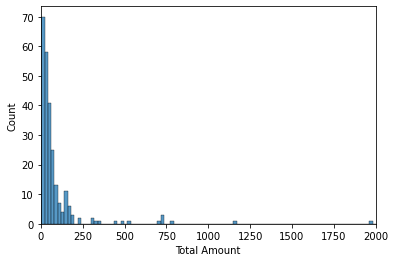

In [ ]:
import seaborn as sns

fig, ax = plt.subplots()
ax.set_xlim(0, 2000)
sns.histplot(pd.concat([data_csv['Total Amount'], data_test['Total Amount']]),
             ax=ax)

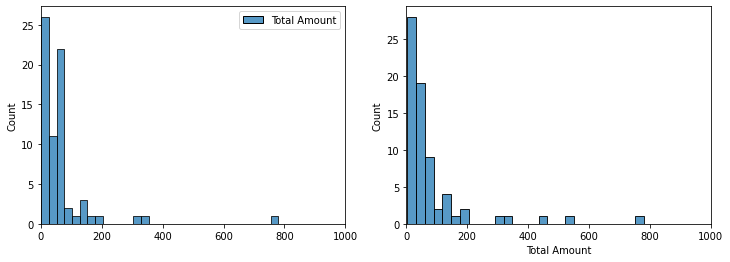

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
ax[0].set_xlim(0, 1000)
ax[1].set_xlim(0, 1000)
sns.histplot(test_pred,
             ax=ax[0])
sns.histplot(data_test['Total Amount'],
             ax=ax[1])